In [1]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip install smplx
!pip install opencv-python
!pip install trimesh
!pip install pyrender
!pip install matplotlib
!pip install pyopengl
!pip install mediapipe


Looking in indexes: https://download.pytorch.org/whl/cpu
  Using cached numpy-2.2.6-cp311-cp311-win_amd64.whl.metadata (60 kB)
Using cached numpy-2.2.6-cp311-cp311-win_amd64.whl (12.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mediapipe 0.10.21 requires numpy<2, but you have numpy 2.2.6 which is incompatible.


  Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl (15.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.


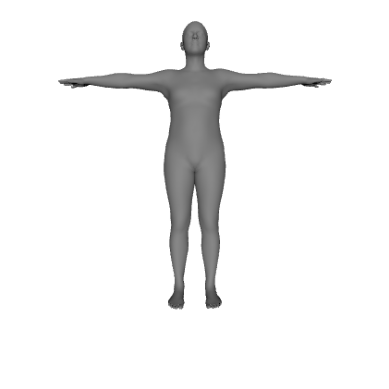

In [2]:
import torch
import smplx
import numpy as np
import trimesh
import pyrender
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# ========== Load SMPL model ==========
MODEL_PATH = "./SMPL_models"   # <-- replace with the folder containing smpl.pkl
smpl = smplx.SMPL(model_path=MODEL_PATH, gender="NEUTRAL").to("cpu")

# Neutral pose
betas = torch.zeros([1, 10], device="cpu")
body_pose = torch.zeros([1, 69], device="cpu")
global_orient = torch.zeros([1, 3], device="cpu")

output = smpl(betas=betas, body_pose=body_pose, global_orient=global_orient)
vertices = output.vertices[0].detach().cpu().numpy()
faces = smpl.faces

# ========== Convert to Trimesh ==========
mesh = trimesh.Trimesh(vertices, faces, process=False)

# ========== Pyrender scene ==========
mesh_pr = pyrender.Mesh.from_trimesh(mesh, smooth=True)
scene = pyrender.Scene()
scene.add(mesh_pr)

# Camera
camera = pyrender.PerspectiveCamera(yfov=np.pi / 3.0)
camera_pose = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, -0.5],
    [0, 0, 1, 2.0],
    [0, 0, 0, 1]
])
scene.add(camera, pose=camera_pose)

# Light
light = pyrender.DirectionalLight(color=np.ones(3), intensity=3.0)
scene.add(light, pose=np.eye(4))

# Renderer (small size for CPU speed)
r = pyrender.OffscreenRenderer(400, 400)
color, depth = r.render(scene)

# Show result
plt.imshow(color)
plt.axis("off")
plt.show()


In [3]:
import trimesh
import pyrender
import numpy as np

try:
    np.infty
except AttributeError:
    np.infty = np.inf

# -------------------------------
# Load OBJ (automatically reads MTL)
# -------------------------------
OBJ_PATH = "./database/13647_Polo_Team_Shirt_v2_L3.obj"
mesh = trimesh.load(OBJ_PATH, force='mesh', process=False)

# -------------------------------
# Remove invalid vertices (inf or NaN)
# -------------------------------
vertices = mesh.vertices.copy()
# This line correctly handles both positive and negative infinity, and NaNs.
# It is the modern, correct way to check for finite values in NumPy.
vertices[~np.isfinite(vertices)] = 0
mesh.vertices = vertices

# -------------------------------
# Check if texture/material is loaded
# -------------------------------
if mesh.visual.kind != 'texture':
    raise ValueError("⚠ OBJ has no texture. Check that MTL points to the correct file.")
else:
    print("✅ OBJ has texture loaded from MTL.")

# -------------------------------
# Convert to Pyrender mesh
# -------------------------------
pyr_mesh = pyrender.Mesh.from_trimesh(mesh, smooth=True)

# -------------------------------
# Create scene
# -------------------------------
scene = pyrender.Scene(bg_color=[1, 1, 1, 1], ambient_light=[0.5, 0.5, 0.5])
scene.add(pyr_mesh)

# -------------------------------
# Viewer
# -------------------------------
pyrender.Viewer(scene, use_raymond_lighting=True)


✅ OBJ has texture loaded from MTL.


Viewer=(width=640, height=480)

In [4]:
import trimesh
import pyrender
import numpy as np
import cv2
from trimesh.transformations import rotation_matrix

# -------------------------------
# Load polo mesh
# -------------------------------
OBJ_PATH = "./database/13647_Polo_Team_Shirt_v2_L3.obj"
polo_mesh = trimesh.load(OBJ_PATH, force='mesh', process=False)

# Rotate polo upright if needed
R = rotation_matrix(np.radians(-90), [-1, 0, 0])
polo_mesh.apply_transform(R)

# Convert to pyrender mesh
pyr_polo = pyrender.Mesh.from_trimesh(polo_mesh, smooth=True)

# Scene with transparent background
scene = pyrender.Scene(bg_color=[0, 0, 0, 0], ambient_light=[0.6, 0.6, 0.6])
scene.add(pyr_polo)

# Add camera (front view)
camera = pyrender.PerspectiveCamera(yfov=np.pi/3.0)
camera_pose = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0.7],
    [0, 0, 1, 2.0],
    [0, 0, 0, 1]
])
scene.add(camera, pose=camera_pose)

# Lighting
light = pyrender.DirectionalLight(color=np.ones(3), intensity=3.0)
scene.add(light, pose=camera_pose)

# Render offscreen
renderer = pyrender.OffscreenRenderer(viewport_width=512, viewport_height=512)
color, _ = renderer.render(scene)

# Save with alpha channel
output_path = "./assets/polo_overlay.png"
cv2.imwrite(output_path, cv2.cvtColor(color, cv2.COLOR_RGBA2BGRA))
print(f"Saved polo overlay at {output_path}")


Saved polo overlay at ./assets/polo_overlay.png


In [7]:
## import torch
import trimesh
import pyrender
import numpy as np
from smplx import SMPL
from trimesh.transformations import rotation_matrix
from scipy.spatial import cKDTree

# -------------------------------
# 0. NumPy 2.0 compatibility
# -------------------------------
try:
    np.infty
except AttributeError:
    np.infty = np.inf

# -------------------------------
# 1. Load and Pose SMPL body
# -------------------------------
smpl_model_path = "./smpl_models"
smpl = SMPL(model_path=smpl_model_path, gender='NEUTRAL')

betas = torch.zeros([1, 10], dtype=torch.float32)
global_orient = torch.zeros([1, 3], dtype=torch.float32)
body_pose = torch.zeros([1, 69], dtype=torch.float32)

# Rotate arms down ~35° around X-axis
angle = np.radians(-35)

# Left shoulder
body_pose[0, 48] = angle  # rotation around X
# Right shoulder
body_pose[0, 51] = angle  # rotation around X


# Neutral SMPL mesh for alignment
neutral_output = smpl(betas=betas, body_pose=torch.zeros([1,69]), global_orient=torch.zeros([1,3]), return_verts=True)
neutral_vertices = neutral_output.vertices.detach().cpu().numpy().squeeze()
neutral_smpl_mesh = trimesh.Trimesh(vertices=neutral_vertices, faces=smpl.faces, process=False)

# Posed SMPL
posed_output = smpl(betas=betas, body_pose=body_pose, global_orient=global_orient, return_verts=True)
posed_vertices = posed_output.vertices.detach().cpu().numpy().squeeze()
smpl_mesh = trimesh.Trimesh(vertices=posed_vertices, faces=smpl.faces, process=False)
smpl_mesh.apply_translation([0, 1, 0])  # adjust value as needed


# -------------------------------
# 2. Load polo and align to SMPL torso
# -------------------------------
OBJ_PATH = "./database/13647_Polo_Team_Shirt_v2_L3.obj"
polo_mesh = trimesh.load(OBJ_PATH, force='mesh', process=False)

R = rotation_matrix(np.radians(-90), [-1, 0, 0])
polo_mesh.apply_transform(R)

# Compute SMPL torso bounding box (mid chest to waist)
smpl_bbox = neutral_smpl_mesh.bounds
smpl_torso_min = smpl_bbox[0] + [0, 5 *(smpl_bbox[1][1] + smpl_bbox[0][1]), 6.2]
smpl_torso_max = smpl_bbox[1] - [0, 5 *(smpl_bbox[1][1] + smpl_bbox[0][1]), 1.0]
smpl_torso_center = (smpl_torso_min + smpl_torso_max) / 2
smpl_torso_dims = smpl_torso_max - smpl_torso_min

# Polo bbox
polo_bbox = polo_mesh.bounds
polo_dims = polo_bbox[1] - polo_bbox[0]

# Scale polo to fit torso width & depth
scale_factor = min(smpl_torso_dims[1] / polo_dims[0],
                   smpl_torso_dims[2] / polo_dims[0]) * 0.1
polo_mesh.apply_scale(scale_factor)

# Translate polo to torso center
polo_mesh.apply_translation([0, 0.55, 0])  # adjust 0.05 → higher/lower if needed

# -------------------------------
# 3. Deform polo using SMPL offsets
# -------------------------------
offsets = posed_vertices - neutral_vertices
tree = cKDTree(neutral_vertices)
_, nearest_indices = tree.query(polo_mesh.vertices)
posed_polo_vertices = polo_mesh.vertices + offsets[nearest_indices]

posed_polo_mesh = trimesh.Trimesh(vertices=posed_polo_vertices, faces=polo_mesh.faces, visual=polo_mesh.visual, process=False)

# -------------------------------
# 4. Pyrender visualization
# -------------------------------
# Set light grey color for SMPL
smpl_mesh.visual.vertex_colors = [0.9, 0.9, 0.9, 1.0]

pyr_smpl = pyrender.Mesh.from_trimesh(smpl_mesh, smooth=True)
pyr_polo = pyrender.Mesh.from_trimesh(posed_polo_mesh, smooth=True)

scene = pyrender.Scene(bg_color=[1,1,1,1], ambient_light=[0.5,0.5,0.5])
scene.add(pyr_smpl)
scene.add(pyr_polo)

# Camera positioned for **front view**
camera = pyrender.PerspectiveCamera(yfov=np.pi/3.0)
camera_pose = np.array([
    [1, 0, 0, 0],   # X axis
    [0, 1, 0, 0.9], # Y axis (slightly lower than before to center torso)
    [0, 0, 1, 2.8], # Z axis (a bit closer for centering)
    [0, 0, 0, 1]
])
scene.add(camera, pose=camera_pose)

pyrender.Viewer(scene, use_raymond_lighting=True)


Viewer=(width=640, height=480)

In [8]:
import cv2
import mediapipe as mp
import numpy as np
import trimesh
import pyrender
from trimesh.transformations import rotation_matrix
from PIL import Image

# ================================
# 1. Load Polo Mesh and Texture
# ================================
OBJ_PATH = "./database/13647_Polo_Team_Shirt_v2_L3.obj"
TEXTURE_PATH = "./database/13647PoloTeamShirt_cloth_diffuse.jpg"

polo_mesh = trimesh.load(OBJ_PATH, force='mesh', process=False)

# Front-facing correction
polo_mesh.apply_transform(rotation_matrix(np.radians(-90), [-1, 0, 0]))
polo_mesh.apply_transform(rotation_matrix(np.pi, [0, 1, 0]))

# Move origin to top-center for alignment
bounds = polo_mesh.bounds
top_center = np.array([(bounds[0][0]+bounds[1][0])/2, bounds[1][1], (bounds[0][2]+bounds[1][2])/2])
polo_mesh.apply_translation(-top_center)

# Load texture
material = None
try:
    pil_image = Image.open(TEXTURE_PATH).convert('RGB')
    img_np = np.array(pil_image, dtype=np.uint8)
    texture = pyrender.Texture(source=img_np)
    material = pyrender.MetallicRoughnessMaterial(
        baseColorTexture=texture,
        metallicFactor=0.0,
        roughnessFactor=0.8
    )
except Exception as e:
    print(f"Failed to load texture: {e}")
    material = None

# ================================
# 2. MediaPipe Pose Detector
# ================================
mp_pose = mp.solutions.pose
pose_detector = mp_pose.Pose(
    static_image_mode=False,
    model_complexity=1,
    enable_segmentation=False,
    min_detection_confidence=0.5
)

# ================================
# 3. Pyrender Scene & Camera
# ================================
scene = pyrender.Scene(bg_color=[0,0,0,0], ambient_light=[0.7,0.7,0.7])
renderer = pyrender.OffscreenRenderer(640, 480)

if material:
    pyr_polo = pyrender.Mesh.from_trimesh(polo_mesh, material=material, smooth=True)
else:
    pyr_polo = pyrender.Mesh.from_trimesh(polo_mesh, smooth=True)
node_polo = scene.add(pyr_polo)

camera = pyrender.PerspectiveCamera(yfov=np.pi/3.0)
camera_pose = np.array([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,2.0],  # adjust distance
    [0,0,0,1]
])
scene.add(camera, pose=camera_pose)

# ================================
# 4. Helper Functions
# ================================
def lm_to_array(lm, w, h):
    return np.array([lm.x * w, lm.y * h])

FOCAL_LENGTH = 600
TORSO_WIDTH_WORLD = 0.4  # meters

# ================================
# 5. Virtual Try-On Loop
# ================================
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    h, w, _ = frame.shape
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = pose_detector.process(rgb)

    if results.pose_landmarks:
        lm = results.pose_landmarks.landmark
        # Shoulder and hip points
        left_sh = lm_to_array(lm[11], w, h)
        right_sh = lm_to_array(lm[12], w, h)
        left_hip = lm_to_array(lm[23], w, h)
        right_hip = lm_to_array(lm[24], w, h)

        # Convert 2D landmarks to approximate 3D
        shoulder_width_px = np.linalg.norm(right_sh - left_sh)
        torso_height_px = np.linalg.norm(((left_sh+right_sh)/2)-((left_hip+right_hip)/2))
        z_depth = FOCAL_LENGTH * TORSO_WIDTH_WORLD / shoulder_width_px

        def to_3d(px):
            return np.array([
                (px[0]-w/2)*z_depth/FOCAL_LENGTH,
                -(px[1]-h/2)*z_depth/FOCAL_LENGTH,
                z_depth
            ])

        left_sh_3d = to_3d(left_sh)
        right_sh_3d = to_3d(right_sh)
        left_hip_3d = to_3d(left_hip)
        right_hip_3d = to_3d(right_hip)

        # Torso axes
        torso_center = (left_sh_3d+right_sh_3d+left_hip_3d+right_hip_3d)/4
        torso_x = right_sh_3d - left_sh_3d
        torso_y = ((left_hip_3d+right_hip_3d)/2 - (left_sh_3d+right_sh_3d)/2)
        torso_z = np.cross(torso_x, torso_y)
        torso_x /= np.linalg.norm(torso_x)
        torso_y /= np.linalg.norm(torso_y)
        torso_z /= np.linalg.norm(torso_z)

        # Rotation matrix
        R = np.eye(4)
        R[:3,0] = torso_x
        R[:3,1] = torso_y
        R[:3,2] = torso_z

        # Scale shirt to match shoulders
        polo_copy = polo_mesh.copy()
        mesh_width = polo_copy.bounds[1][0] - polo_copy.bounds[0][0]
        mesh_height = polo_copy.bounds[1][1] - polo_copy.bounds[0][1]
        scale_x = np.linalg.norm(right_sh_3d-left_sh_3d)/mesh_width
        scale_y = np.linalg.norm(torso_y)/mesh_height
        scale_z = (scale_x+scale_y)/2
        polo_copy.apply_scale([scale_x, scale_y, scale_z])

        # Apply rotation
        polo_copy.apply_transform(R)

        # Translate to torso
        mesh_center = (polo_copy.bounds[0]+polo_copy.bounds[1])/2
        translation = torso_center - mesh_center
        polo_copy.apply_translation(translation)

        # Update Pyrender mesh
        scene.remove_node(node_polo)
        if material:
            pyr_polo = pyrender.Mesh.from_trimesh(polo_copy, material=material, smooth=True)
        else:
            pyr_polo = pyrender.Mesh.from_trimesh(polo_copy, smooth=True)
        node_polo = scene.add(pyr_polo)

        # Draw landmarks for debug
        for p in [left_sh, right_sh, left_hip, right_hip]:
            cv2.circle(frame, tuple(p.astype(int)), 5, (0,255,0), -1)

    # Render & overlay
    color, _ = renderer.render(scene)
    frame = cv2.addWeighted(frame, 0.4, cv2.resize(color,(w,h)), 0.6,0)
    cv2.imshow("Virtual Try-On AR", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
renderer.delete()


Failed to load texture: Invalid texture channel specification: None
